In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt 
import seaborn as sns
from PIL import Image
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

import keras
from keras.layers import Dense, Conv2D
from keras.layers import Flatten
from keras.layers import MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.models import Sequential
from keras import backend as K

from keras import optimizers

print("TF Version: ", tf.__version__)
import tensorflow_hub as hub
print("TF Hub Version: ", hub.__version__)

#GPU availability 
print("GPU", "available (Yesss!!!!)" if tf.config.list_physical_devices("GPU") else " Not Available ")

TF Version:  2.7.0
TF Hub Version:  0.12.0
GPU available (Yesss!!!!)


In [2]:
parasitized_data = os.listdir('/content/drive/MyDrive/Dissertation /cell_image/Parasitized/')
print(parasitized_data[:10]) #the output we get are the .png files

uninfected_data = os.listdir('/content/drive/MyDrive/Dissertation /cell_image/Uninfected/')
print('\n')
print(uninfected_data[:10])

['C97P58ThinF_IMG_20150917_145555_cell_167.png', 'C93P54ThinF_IMG_20150821_163640_cell_202 (8).png', 'C95P56ThinF_IMG_20150821_171701_cell_95.png', 'C97P58ThinF_IMG_20150917_151437_cell_156.png', 'C97P58ThinF_IMG_20150917_152032_cell_153.png', 'C97P58ThinF_IMG_20150917_151320_cell_148.png', 'C97P58ThinF_IMG_20150917_151437_cell_166.png', 'C97P58ThinF_IMG_20150917_145555_cell_188.png', 'C97P58ThinF_IMG_20150917_151903_cell_30.png', 'C97P58ThinF_IMG_20150917_152032_cell_164.png']


['C7NthinF_IMG_20150611_104753_cell_163.png', 'C82P43ThinF_IMG_20150817_124418_cell_98.png', 'C86P47ThinF_IMG_20150820_124025_cell_116.png', 'C83P44ThinF_IMG_20150817_134820_cell_100.png', 'C69P30N_ThinF_IMG_20150819_135421_cell_186.png', 'C82P43ThinF_IMG_20150817_124418_cell_121.png', 'C92P53ThinF_IMG_20150821_150718_cell_133.png', 'C72P33_ThinF_IMG_20150815_104923_cell_216.png', 'C71P32_ThinF_IMG_20150813_162016_cell_108.png', 'C75P36_ThinF_IMG_20150815_163707_cell_44.png']


In [3]:
data = []
labels = []
for img in parasitized_data:
    try:
        img_read = plt.imread('/content/drive/MyDrive/Dissertation /cell_image/Parasitized' + "/" + img)
        img_resize = cv2.resize(img_read, (50, 50))
        img_array = img_to_array(img_resize)
        data.append(img_array)
        labels.append(1)
    except:
        None
        
for img in uninfected_data:
    try:
        img_read = plt.imread('/content/drive/MyDrive/Dissertation /cell_image/Uninfected' + "/" + img)
        img_resize = cv2.resize(img_read, (50, 50))
        img_array = img_to_array(img_resize)
        data.append(img_array)
        labels.append(0)
    except:
        None

In [4]:
image_data = np.array(data)
labels = np.array(labels)

In [5]:
idx = np.arange(image_data.shape[0])
np.random.shuffle(idx)
image_data = image_data[idx]
labels = labels[idx]

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(image_data, labels, test_size = 0.2, random_state = 101)

In [7]:
y_train = np_utils.to_categorical(y_train, num_classes = 2)
y_test = np_utils.to_categorical(y_test, num_classes = 2)

In [8]:
print(f'SHAPE OF TRAINING IMAGE DATA : {x_train.shape}')
print(f'SHAPE OF TESTING IMAGE DATA : {x_test.shape}')
print(f'SHAPE OF TRAINING LABELS : {y_train.shape}')
print(f'SHAPE OF TESTING LABELS : {y_test.shape}')

SHAPE OF TRAINING IMAGE DATA : (22374, 50, 50, 3)
SHAPE OF TESTING IMAGE DATA : (5594, 50, 50, 3)
SHAPE OF TRAINING LABELS : (22374, 2)
SHAPE OF TESTING LABELS : (5594, 2)


In [9]:
def CNNbuild(height, width, classes, channels):
    model = Sequential()
    
    inputShape = (height, width, channels)
    chanDim = -1
    
    if K.image_data_format() == 'channels_first':
        inputShape = (channels, height, width)
    model.add(Conv2D(32, (3,3), activation = 'relu', input_shape = inputShape))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))

    model.add(Flatten())
    
    model.add(Dense(512, activation = 'relu'))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.5))
    model.add(Dense(classes, activation = 'softmax'))
    
    return model

In [10]:
train_datagen = ImageDataGenerator(rescale = 1/255.,
                                  horizontal_flip = True,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  fill_mode = 'nearest',
                                  zoom_range = 0.3,
                                  rotation_range = 30)
val_datagen = ImageDataGenerator(rescale = 1/255.)

train_generator = train_datagen.flow(x_train, y_train, batch_size = 64, shuffle = False)
val_generator = val_datagen.flow(x_test, y_test, batch_size = 64, shuffle = False)

In [11]:
height = 50
width = 50
classes = 2
channels = 3

In [12]:
#calling the same model as above
model = CNNbuild(height = height, width = width, classes = classes, channels = channels)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 24, 24, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 32)       0

In [14]:
#compile the model
optim = tf.keras.optimizers.Adam(lr = 0.001, decay = 0.001 / 64)
model.compile(loss = 'categorical_crossentropy', optimizer = optim, metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [15]:
#fit the model on the augmented dataset
history = model.fit_generator(train_generator, steps_per_epoch = len(x_train) // 64, epochs = 50, validation_data= val_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
349/349 [==============================] - 42s 82ms/step - loss: 0.8217 - accuracy: 0.6043 - val_loss: 0.6911 - val_accuracy: 0.4930
Epoch 2/50
349/349 [==============================] - 28s 80ms/step - loss: 0.5439 - accuracy: 0.7307 - val_loss: 0.6293 - val_accuracy: 0.6857
Epoch 3/50
349/349 [==============================] - 28s 80ms/step - loss: 0.3871 - accuracy: 0.8346 - val_loss: 0.2152 - val_accuracy: 0.9212
Epoch 4/50
349/349 [==============================] - 28s 80ms/step - loss: 0.3441 - accuracy: 0.8599 - val_loss: 0.2007 - val_accuracy: 0.9262
Epoch 5/50
349/349 [==============================] - 28s 80ms/step - loss: 0.3184 - accuracy: 0.8744 - val_loss: 0.2281 - val_accuracy: 0.9430
Epoch 6/50
349/349 [==============================] - 28s 80ms/step - loss: 0.3039 - accuracy: 0.8840 - val_loss: 0.2295 - val_accuracy: 0.9367
Epoch 7/50
349/349 [==============================] - 28s 80ms/step - loss: 0.2923 - accuracy: 0.8898 - val_loss: 0.1938 - val_accuracy:

In [16]:
#evaluate the model on augmented test data
predict = model.evaluate_generator(val_generator, steps = 5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


In [17]:
print(f'LOSS ON TEST DATA AFTER DATA AUGMENTATION : {predict[0]}')
print(f'ACCURACY ON TEST DATA AFTER DATA AUGMENTATION : {predict[1]}')

LOSS ON TEST DATA AFTER DATA AUGMENTATION : 0.10278858989477158
ACCURACY ON TEST DATA AFTER DATA AUGMENTATION : 0.9781249761581421


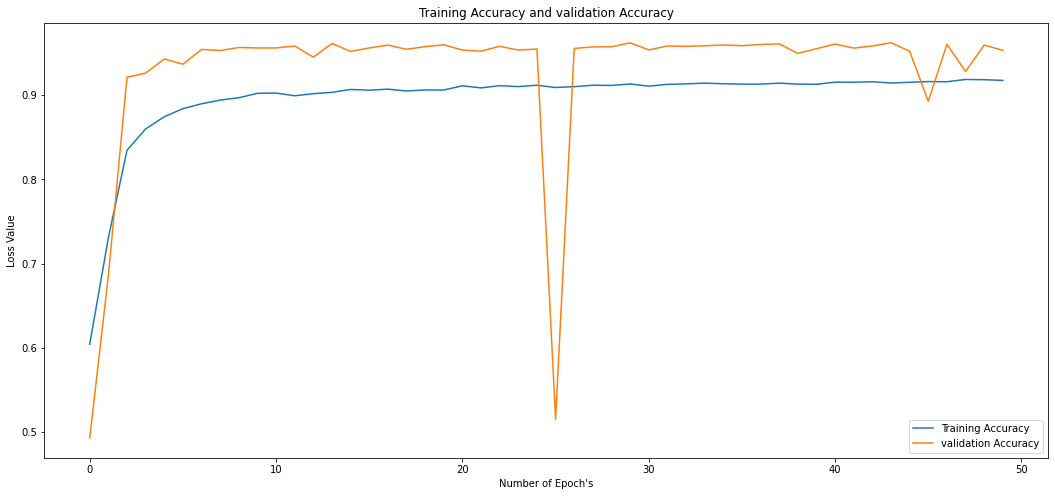

In [18]:
plt.figure(figsize = (18,8))
plt.plot(range(50), history.history['accuracy'], label = 'Training Accuracy')
plt.plot(range(50), history.history['val_accuracy'], label = 'validation Accuracy')
#ax1.set_xticks(np.arange(0, 31, 5))
plt.xlabel("Number of Epoch's")
plt.ylabel('Accuracy Value')
plt.title('Training Accuracy and validation Accuracy')
plt.legend(loc = "best")


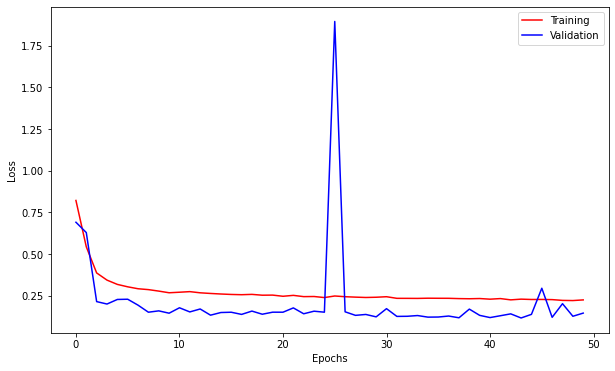

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

fig = plt.figure(figsize=(10,6))
plt.plot(epochs,loss,c="red",label="Training")
plt.plot(epochs,val_loss,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss value")
plt.legend()

In [20]:
# # Convert the model.
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# # Save the model.
# with open('model.tflite', 'wb') as f:
#   f.write(tflite_model)